# DyNet vs PyTorch

In [1]:
%matplotlib inline
from random import choice, randrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import random

EOS = "<EOS>" #all strings will end with the End Of String token
PAD = "<PAD>"
characters = list("abcd")
characters.append(EOS)
characters.append(PAD)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)
PAD_IDX = VOCAB_SIZE - 1

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-2]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]  # Return the random string and its reverse
    

MIN_STRING_LEN = 1
MAX_STRING_LEN = 10
TRAIN_SET_SIZE = 5000
VAL_SET_SIZE = 10

batch_size = 1

RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
STATE_SIZE = 64

default_epochs = 20

train_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(TRAIN_SET_SIZE)]
val_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(VAL_SET_SIZE)]

# DyNet Attention Model

In [2]:
import matplotlib.pyplot as plt
import dynet as dy
from tqdm import tqdm
def train_dynet(network, train_set, val_set, epochs = default_epochs):
    def get_val_set_loss(network, val_set):
        loss = [network.get_loss(input_string, output_string).value() for input_string, output_string in val_set]
        return sum(loss)
    
    train_set = train_set*epochs
    trainer = dy.SimpleSGDTrainer(network.model)
    losses = []
    iterations = []
    for i, training_example in enumerate(tqdm(train_set)):
        input_string, output_string = training_example
        
        loss = network.get_loss(input_string, output_string)
        loss_value = loss.value()
        loss.backward()
        trainer.update()

        # Accumulate average losses over training to plot
        if i%(len(train_set)/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))

    plt.plot(iterations, losses)
    plt.axis([0, 100, 0, len(val_set)*MAX_STRING_LEN])
    plt.show() 
    print('loss on validation set:', val_loss)

In [3]:
RNN_BUILDER = dy.LSTMBuilder
    
class AttentionDyNet():
    def __init__(self, num_of_layers, embeddings_size, state_size):
        self.model = dy.Model()

        # the embedding paramaters
        self.embeddings = self.model.add_lookup_parameters((VOCAB_SIZE, embeddings_size))

        # the rnns
        self.ENC_RNN = RNN_BUILDER(num_of_layers, embeddings_size, state_size, self.model)
        self.DEC_RNN = RNN_BUILDER(num_of_layers, state_size, state_size, self.model)

        # project the rnn output to a vector of VOCAB_SIZE length
        self.output_w = self.model.add_parameters((VOCAB_SIZE, state_size))
        self.output_b = self.model.add_parameters((VOCAB_SIZE))

        # attention weights
        self.attention_w1 = self.model.add_parameters((state_size, state_size))
        self.attention_w2 = self.model.add_parameters((state_size, state_size))
        self.attention_v = self.model.add_parameters((1, state_size))

        self.state_size = state_size
        
    def _add_eos(self, string):
        string = list(string) + [EOS]
        return [char2int[c] for c in string]
    
    def _embed_string(self, string):
        return [self.embeddings[char] for char in string]

    def _run_rnn(self, init_state, input_vecs):
        s = init_state

        states = s.add_inputs(input_vecs)
        rnn_outputs = [s.output() for s in states]
        return rnn_outputs
    
    def _get_probs(self, rnn_output):
        output_w = dy.parameter(self.output_w)
        output_b = dy.parameter(self.output_b)

        probs = dy.softmax(output_w * rnn_output + output_b)
        return probs
    
            
    def get_loss(self, input_string, output_string):
        input_string = self._add_eos(input_string)
        output_string = self._add_eos(output_string)

        dy.renew_cg()

        probs = self(input_string)
        loss = [-dy.log(dy.pick(p, output_char)) for p, output_char in zip(probs, output_string)]
        loss = dy.esum(loss)
        return loss

    def _predict(self, probs):
        probs = probs.value()
        predicted_char = int2char[probs.index(max(probs))]
        return predicted_char
    
    def generate(self, input_string):
        input_string = self._add_eos(input_string)

        dy.renew_cg()
        
        probs = self(input_string)
        output_string = [self._predict(p) for p in probs]
        output_string = ''.join(output_string)
        return output_string.replace('<EOS>', '')
    
    def _attend(self, input_vectors, state):
        w1 = dy.parameter(self.attention_w1)
        w2 = dy.parameter(self.attention_w2)
        v = dy.parameter(self.attention_v)
        attention_weights = []

        w2dt = w2 * state.h()[-1]
        for input_vector in input_vectors:
            attention_weight = v * dy.tanh(w1 * input_vector + w2dt)
            attention_weights.append(attention_weight)
        attention_weights = dy.softmax(dy.concatenate(attention_weights))

        output_vectors = dy.esum(
            [vector * attention_weight for vector, attention_weight in zip(input_vectors, attention_weights)])
        return output_vectors
    
    def _encode_string(self, embedded_string):
        initial_state = self.ENC_RNN.initial_state()
        # run_rnn returns all the hidden state of all the slices of the RNN
        hidden_states = self._run_rnn(initial_state, embedded_string)

        return hidden_states
    
    def __call__(self, input_string):
        dy.renew_cg()

        embedded_string = self._embed_string(input_string)
        encoded_string = self._encode_string(embedded_string)

        rnn_state = self.DEC_RNN.initial_state().add_input(dy.vecInput(self.state_size))

        probs = []
        for _ in range(len(input_string)):
            attended_encoding = self._attend(encoded_string, rnn_state)
            rnn_state = rnn_state.add_input(attended_encoding)
            p = self._get_probs(rnn_state.output())
            probs.append(p)
        return probs


# PyTorch Attention Model

In [4]:
def _preprocess_string(strings):
    batch_size = len(strings)

    strings_with_eos = [list(string) + [EOS] for string in strings]
    max_len = max([len(string) for string in strings_with_eos])
    padded_strings = [string + [PAD] * (max_len - len(string)) for string in strings_with_eos]
    #len_first = [[padded_strings[j][i]for j in range(batch_size)] for i in range(max_len)]
    #int_strings = [[char2int[c] for c in string] for string in len_first]
    int_strings = [[char2int[c] for c in string] for string in padded_strings]
    var = Variable(torch.LongTensor(int_strings))
    return var

def get_loss(network, input_strings, output_strings):
    batch_size = len(output_strings)
    input_strings_t = _preprocess_string(input_strings)
    output_strings_t = _preprocess_string(output_strings)

    probs = network(input_strings_t, batch_size).permute(1, 0, 2)

    loss = sum([F.cross_entropy(p, t, ignore_index=PAD_IDX) for p, t in zip(probs, output_strings_t)])
    #loss = F.cross_entropy(probs.unsqueeze(0) , output_strings_t, ignore_index=PAD_IDX, size_average=False) 

    return loss

def generate(network, input_string):
    input_string = _preprocess_string([input_string])
    probs = network(input_string, 1)
    generated = [int2char[prob[0].topk(1)[1][0]] for prob in probs.data]
    return (''.join(generated)).split(EOS)[0].replace(PAD, '')

def batcher(dataset, epochs = 1):
    sources, targets = [], []
    i = 0
    for _ in range(epochs):
        for source, target in dataset:
            i+=1
            sources.append(source), targets.append(target)
            if len(sources) >= batch_size:
                yield sources, targets
                sources, targets = [], []
    if sources: yield sources, targets
        
def train(network, train_set, val_set, epochs=default_epochs):
    def get_val_set_loss(network, val_set):
        losses = [get_loss(network, input_strings, output_strings).data[0]
                 for input_strings, output_strings in batcher(val_set)]
        return sum(losses)
    losses = []
    iterations = []
    optim = torch.optim.SGD(network.parameters(), lr = 0.1)
    
    total_iterations = max(int((len(train_set)*epochs)/batch_size), 100)
    for i, (input_strings, output_strings) in enumerate(tqdm(batcher(train_set, epochs=epochs))):
              
        optim.zero_grad()
        loss = get_loss(network, input_strings, output_strings)
        loss.backward()
        optim.step()
            
        # Accumulate average losses over training to plot
        if i%int(total_iterations/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))

    plt.plot(iterations, losses)
    plt.axis([0, 100, 0, 100])
    plt.show() 
    print('loss on validation set:', val_loss)

In [5]:
class AttentionPyTorch(nn.Module):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(AttentionPyTorch, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size, padding_idx=PAD_IDX)

        self.enc = nn.LSTM(embeddings_size, state_size, num_of_layers)
        self.dec = nn.LSTM(state_size, state_size, num_of_layers)
        
        self.linear = nn.Linear(state_size, VOCAB_SIZE)
        # the attention
        self.att_w1 = nn.Linear(state_size, state_size, bias=False)
        self.att_w2 = nn.Linear(state_size, state_size)
        self.att_v = nn.Linear(state_size, 1)
    
    def get_rnn_init_state(self, batch_size):
        h0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        c0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        return h0, c0
    
    def encode(self, encoder_outputs, decoder_state):
        decoder_state = decoder_state[-1].unsqueeze(0) # Use only the last layer
        unnormalized_att = self.att_v(F.tanh(self.att_w1(decoder_state) + self.att_w2(encoder_outputs)))
        #att = F.softmax(unnormalized_att)
        att = F.softmax(unnormalized_att.permute(1,0,2), dim=1).permute(1,0,2)
        attended = encoder_outputs.mul(att).sum(0)
        return attended.unsqueeze(0)
    
    def forward(self, input_string, batch_size):
        embedded = self.embeddings(input_string.permute(1, 0))
        encoder_outputs, hn = self.enc(embedded, self.get_rnn_init_state(batch_size))
        
        hidden = self.get_rnn_init_state(batch_size)
        
        outputs = []
        for _ in range(len(embedded)):
            encoded = self.encode(encoder_outputs, hidden[0])
            output, hidden = self.dec(encoded, hidden)
            outputs.append(output)
        logits = self.linear(torch.cat(outputs, 0))

        return logits #F.log_softmax(logits, 2)

# Compare

In [6]:
NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
STATE_SIZE = 32

100%|██████████| 100000/100000 [01:17<00:00, 1288.35it/s]


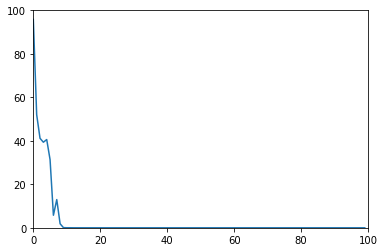

loss on validation set: 0.0005570704197452869
bbdcbadcbacbcb


In [7]:
att_dynet = AttentionDyNet(NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train_dynet(att_dynet, train_set, val_set)
print(att_dynet.generate('abcdabcdabcd'))

100000it [11:02, 151.05it/s]


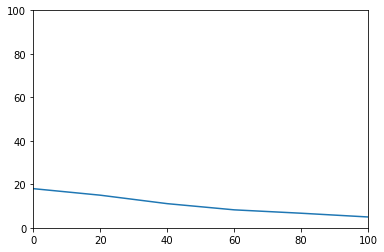

loss on validation set: 0.0008133606133924332
dddcbadcba


In [8]:
att_pytorch = AttentionPyTorch(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(att_pytorch, train_set, val_set)
print(generate(att_pytorch, 'abcdabcdabcd'))